In [1]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

%matplotlib inline

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN,load_model_info
from density_utils import draw_density_ratio, refine_sample_GPC, refine_sample2, draw_density_ratio2, draw_density_ratio_GPC, refine_sample_GP, refine_sample2_GP

from utils import load_item, show_grasp, count_real_positives
from dataset import ToyGraspDataset

%load_ext autoreload
%autoreload 2

# GP Classifier Sim+ vs Real+

In [2]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN, train_network, save_model_info, load_model_info

from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, refine_sample_GP, draw_density_ratio_GP

from utils import load_item, show_grasp
from dataset import ToyGraspDataset

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

torch.manual_seed(42)


sim2real!!!


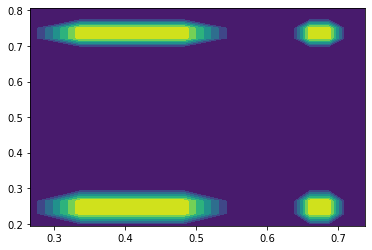

In [7]:
# USING 2D FORK DATA ===============================
n = 10

# train classifier
train_dataset = ToyGraspDataset(root='data', name='sim2real_train', size=100, is_pos_label=True, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='sim2real_test', size=n, is_pos_label=True, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)


# dataset = ToyGraspDataset(root='data', size=50)
train_x = torch.Tensor(train_dataset.data[:,:2])
train_y = torch.Tensor(train_dataset.data[:,2]).long()
# train_y = torch.Tensor(train_dataset.data[:,2]).long() * 2 -1 

train_x[:,0] /= 244
train_x[:,1] /= 2*(3.14)

# y = train_dataset.data[:,2].reshape(-1,1)

test_x = torch.Tensor(test_dataset.data[:,:2])
test_x_mat = torch.reshape(test_x[:,0], (n, n))
test_y_mat = torch.reshape(test_x[:,1], (n, n))

test_x[:,0] /= 244
test_x[:,1] /= 2*(3.14)

test_y = torch.Tensor(test_dataset.data[:,2]).long()
# test_y = torch.Tensor(test_dataset.data[:,2]).long() * 2 -1 
test_labels = torch.reshape(test_y, (n, n))


plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

In [62]:
# print(train_y[train_y==1].sum())
# print(train_y.shape[0])
train_x = torch.linspace(0, 1, 100)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi)))

In [65]:
import gpytorch
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy


class GPClassificationModel(AbstractVariationalGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(self, train_x, variational_distribution)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [66]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 500




# Find optimal model hyperparameters

model.train()
likelihood.train()
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

from gpytorch.mlls.variational_elbo import VariationalELBO
# "Loss" for GPs - the marginal log likelihood
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
mll = VariationalELBO(likelihood, model, train_y.numel())

# train_x = train_x.to(device)
# model = model.to(device)
# likelihood = likelihood.to(device)
# likelihood.transformed_targets = likelihood.transformed_targets.to(device)

model, likelihood, train_x, train_y = model.to(device), likelihood.to(device), train_x.to(device), train_y.to(device)
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 50 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.

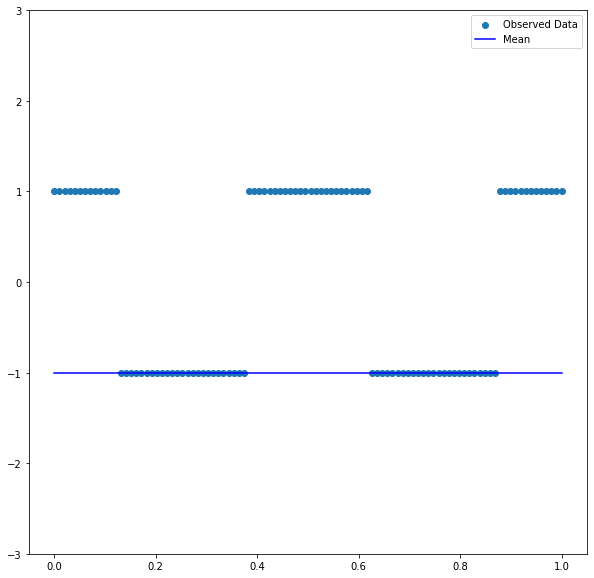

In [61]:
# Go into eval mode
model.eval()
likelihood.eval()


with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(0, 1, 50).to(device)
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.scatter(train_x.cpu().numpy(), train_y.cpu().numpy())
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float().mul(2).sub(1)
    ax.plot(test_x.cpu().numpy(), pred_labels.cpu().numpy(), 'b')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [55]:
observed_pred.mean

tensor([0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4993, 0.4993,
        0.4993, 0.4993, 0.4993, 0.4993, 0.4993, 0.4993, 0.4993, 0.4992, 0.4992,
        0.4992, 0.4992, 0.4992, 0.4992, 0.4992, 0.4992, 0.4992, 0.4992, 0.4992,
        0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991,
        0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991,
        0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991,
        0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991,
        0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991,
        0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4991, 0.4992,
        0.4992, 0.4992, 0.4992, 0.4992, 0.4992, 0.4992, 0.4992, 0.4992, 0.4992,
        0.4992, 0.4993, 0.4993, 0.4993, 0.4993, 0.4993, 0.4993, 0.4993, 0.4993,
        0.4993, 0.4994], device='cuda:0')

tensor([0.1620, 0.1565, 0.1515, 0.1472, 0.1434, 0.1399, 0.1390, 0.1381, 0.1373,
        0.1366, 0.1618, 0.1563, 0.1513, 0.1470, 0.1432, 0.1397, 0.1387, 0.1378,
        0.1371, 0.1363, 0.1618, 0.1562, 0.1512, 0.1468, 0.1431, 0.1395, 0.1385,
        0.1378, 0.1369, 0.1362, 0.1619, 0.1563, 0.1513, 0.1470, 0.1431, 0.1396,
        0.1386, 0.1377, 0.1369, 0.1362, 0.1621, 0.1566, 0.1516, 0.1472, 0.1433,
        0.1397, 0.1387, 0.1379, 0.1370, 0.1363, 0.1740, 0.1682, 0.1630, 0.1584,
        0.1543, 0.1505, 0.1495, 0.1485, 0.1477, 0.1468, 0.1756, 0.1698, 0.1646,
        0.1599, 0.1559, 0.1520, 0.1510, 0.1501, 0.1491, 0.1483, 0.1773, 0.1714,
        0.1662, 0.1617, 0.1576, 0.1537, 0.1527, 0.1516, 0.1508, 0.1499, 0.1791,
        0.1733, 0.1680, 0.1633, 0.1593, 0.1554, 0.1543, 0.1533, 0.1524, 0.1516,
        0.1810, 0.1751, 0.1699, 0.1653, 0.1612, 0.1572, 0.1562, 0.1552, 0.1542,
        0.1533], device='cuda:0')


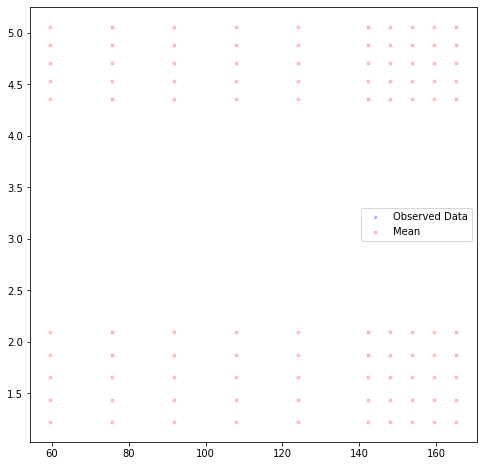

In [35]:
# Go into eval mode
model.eval()
likelihood.eval()
test_x  = test_x.to(device)

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
#     test_x = torch.linspace(0, 1, 101)
    # Get classification predictions
    observed_pred = likelihood(model(test_x))
    print(observed_pred.probs)
  
    
    # Initialize fig and axes for plot
    fig, ax = plt.subplots(nrows=1, figsize=(8,8))
#     pos_masks = train_y == 1
#     neg_masks = ~pos_masks
#     ax.scatter(train_x[pos_masks][:,0]*224, train_x[pos_masks][:,1]*(2*3.14), marker='.', alpha=0.2, color='b')
#     ax.scatter(train_x[neg_masks][:,0]*224, train_x[neg_masks][:,1]*(2*3.14), marker='.', alpha=0.2, color='r')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float().mul(2).sub(1)
#     print(pred_labels.mean)
#     print(test_x.size())
    plot_x = test_x.cpu().numpy()
    
    pos_masks = pred_labels == 1
    neg_masks = ~pos_masks
    pos_masks, neg_masks = pos_masks.cpu(), neg_masks.cpu()
    ax.scatter(plot_x[pos_masks][:,0]*224, plot_x[pos_masks][:,1]*(2*3.14), marker='.', alpha=0.2, color='b')
    ax.scatter(plot_x[neg_masks][:,0]*224, plot_x[neg_masks][:,1]*(2*3.14), marker='.', alpha=0.2, color='r')
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    
    
# fig, ax = plt.subplots(nrows=1, figsize=(8,8))
# pos_masks = train_y == 1
# neg_masks = ~pos_masks
# ax.scatter(train_x[pos_masks][:,0]*224, train_x[pos_masks][:,1]*(2*3.14), marker='.', alpha=0.2, color='b')
# ax.scatter(train_x[neg_masks][:,0]*224, train_x[neg_masks][:,1]*(2*3.14), marker='.', alpha=0.2, color='r')
# plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)


In [109]:
model.eval()
likelihood.eval()
# t_x = test_x.clone().to(device)
with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = likelihood(model(test_x))
#     test_dist = _test_dist.clone().cpu()
    _pred_means = test_dist.mean
    pred_means = _pred_means.clone().cpu()

tensor([[-2.5776e-01, -6.7307e+00,  5.8713e-04],
        [-7.4944e+00, -5.1332e-01, -9.6459e-03]])
Sample 0 : 0.0007192326593212783
Sample 1 : 0.9980095028877258
Sample 2 : 0.49744176864624023


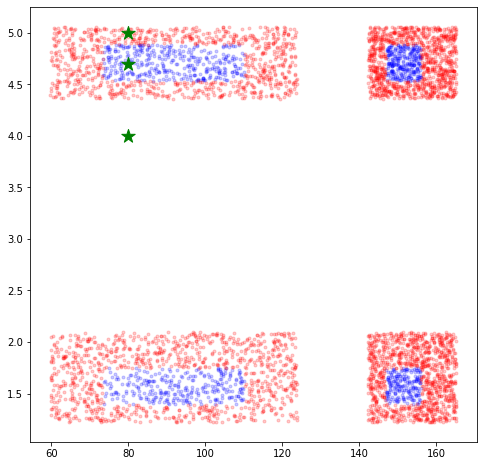

In [120]:
m = nn.Softmax(dim=0)

my_sample = torch.FloatTensor([[80, 5],
                               [80, 4.7],
                               [80, 4]])
my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    means = likelihood(model(my_sample)).mean
    preds = m(means)
#     print(m(preds))

print(means)

for i, sample in enumerate(my_sample):
    print(f"Sample {i} : {preds[1,i]}")
    
fig, ax = plt.subplots(nrows=1, figsize=(8,8))
pos_masks = train_y == 1
neg_masks = ~pos_masks
ax.scatter(train_x[pos_masks][:,0]*224, train_x[pos_masks][:,1]*(2*3.14), marker='.', alpha=0.2, color='b')
ax.scatter(train_x[neg_masks][:,0]*224, train_x[neg_masks][:,1]*(2*3.14), marker='.', alpha=0.2, color='r')
plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)


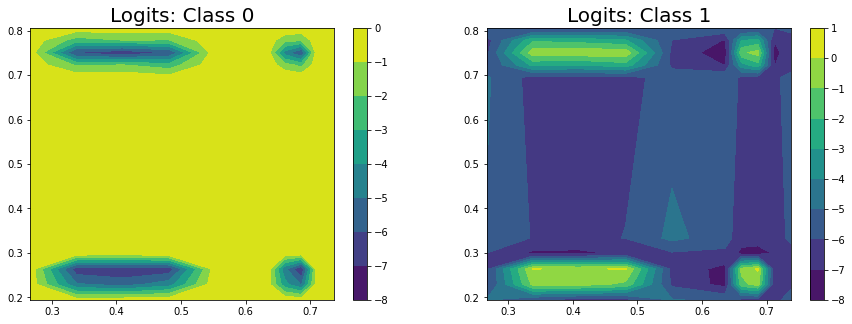

In [90]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

for i in range(2):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((n,n))
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)

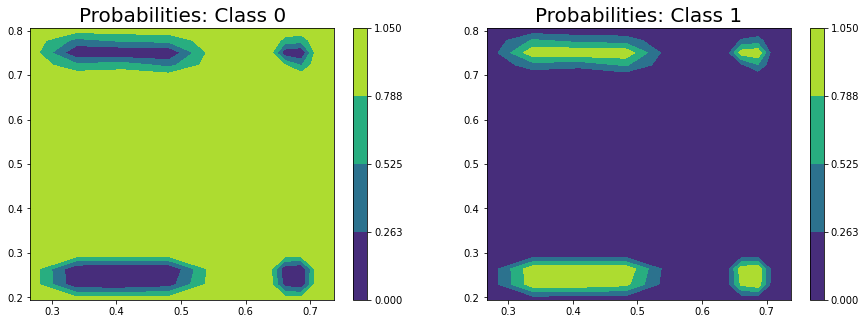

In [91]:
_pred_samples = test_dist.sample(torch.Size((256,))).exp()
pred_samples = _pred_samples.cpu()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

levels = np.linspace(0, 1.05, 5)
for i in range(2):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((n,n)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

Text(0.5, 1.0, 'Estimated Response')

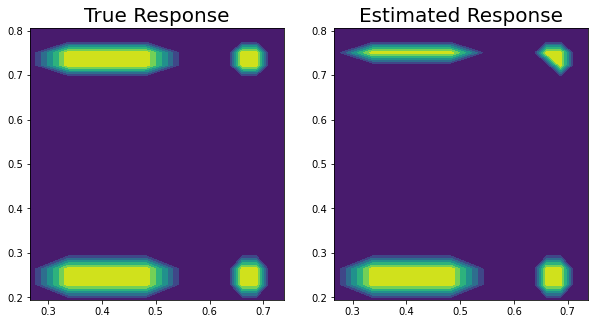

In [39]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.max(0)[1].reshape((n,n)))
ax[1].set_title('Estimated Response', fontsize=20)

Text(0.5, 1.0, 'Estimated Response')

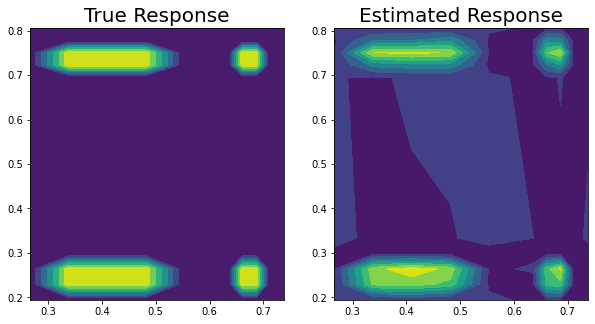

In [40]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)


logit = pred_means[1,:] - pred_means[0,:]
ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), logit.reshape((n,n)))
ax[1].set_title('Estimated Response', fontsize=20)

In [31]:
d_score = pred_means[1,:] - pred_means[0,:]
print(d_score)

tensor([-5.9273, -6.2121, -5.5764, -6.3408, -5.6856, -6.2964, -6.1613, -6.0072,
        -6.3168, -6.1165, -6.2682,  4.3924,  4.9539,  3.3359, -6.2717, -6.4608,
         2.6397,  3.3314, -7.2556, -6.5027, -6.1275,  5.3168,  7.1513,  5.3855,
        -6.2039, -5.8622,  3.4504,  6.3197, -7.5352, -6.5808, -6.1550, -6.7770,
        -6.8189, -6.8721, -6.3731, -6.2628, -6.6502, -6.8846, -6.5262, -6.2969,
        -5.7992, -6.1522, -6.2199, -6.0775, -5.6867, -5.9947, -6.2466, -6.3037,
        -6.2907, -5.8499, -5.9117, -6.1690, -5.8220, -5.7165, -5.8135, -6.2119,
        -6.2152, -5.9348, -6.3299, -6.2041, -6.0419, -1.3450, -0.6297, -0.7397,
        -6.3234, -6.2984, -2.1267,  0.0590, -6.8096, -6.3380, -6.1450,  5.9697,
         6.5019,  5.7922, -6.1668, -6.0038,  3.7087,  5.9179, -7.4085, -6.5300,
        -6.2225, -1.9176, -1.9896, -0.5104, -6.1897, -6.1402, -0.6965, -1.1108,
        -6.8313, -6.3909, -5.9224, -6.0482, -5.6533, -5.9399, -5.8662, -6.0836,
        -6.3574, -5.9870, -6.5689, -6.15

In [32]:
# my_sample = torch.FloatTensor([[60, 1.5],
#                                [80, 1.5]]).to(device)

# my_sample[:,0] /= 224
# my_sample[:,1] /= (2*3.14)


# model.to(device)
# model.eval()
# pred = model(my_sample).mean
# print(pred)
# # print(min(pred).item(), max(pred).item())
next(model.parameters()).is_cuda

False

In [117]:
steps_refinement = 100


# from the GP classifier
# f2
# Nq = info2['pos_samples_size'], Np = info2['neg_samples_size']

Nq = int(train_y.sum())
Np = int(train_y.size()[0] - train_y.sum())

# print(my_sample)
# my_sample = torch.FloatTensor([[25, 0.3],
my_sample = torch.FloatTensor([[60, 1.5],
                               [80, 1.5]])#[160, 3]
# my_sample = torch.FloatTensor([[210, 3]])

my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)

# my_sample = my_sample.repeat(1,200)

# model.to(device)
model.eval()
# likelihood.to(device)
likelihood.eval()

all_x1, all_v1 = refine_sample_GPC(my_sample, model, likelihood, steps=steps_refinement,
# all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, steps=steps_refinement,
#                                eta=0.0001, noise_factor=0.0000,
                               eta=0.1, noise_factor=0.000,
#                                eta=0.5, noise_factor=0.000,
                              Nq = Nq, Np = Np)

1155 3845


  0%|          | 0/100 [00:00<?, ?it/s]

In [118]:
# all_x1
# device

  0%|          | 0/28685 [00:00<?, ?it/s]

-2.7187085 2.2309651


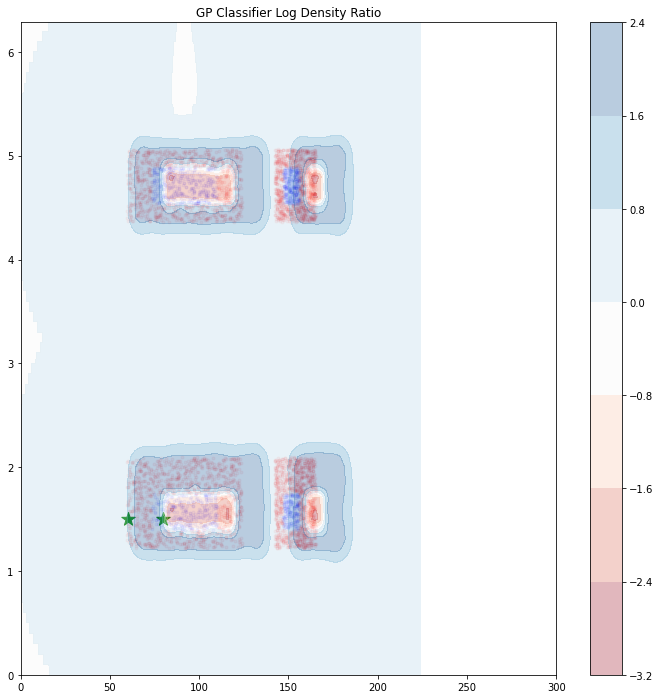

In [119]:
import torch
torch.cuda.empty_cache()

pos_masks = train_y == 1
neg_masks = ~pos_masks
fig, ax = plt.subplots(nrows=1, figsize=(12,12))
ax.scatter(train_x[pos_masks][:,0]*224, train_x[pos_masks][:,1]*(2*3.14), marker='.', alpha=0.05, color='b')
ax.scatter(train_x[neg_masks][:,0]*224, train_x[neg_masks][:,1]*(2*3.14), marker='.', alpha=0.05, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# plt.scatter(my_sample[:, 0], my_sample[:,1], marker='*', color='g', s=200)

for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)
#     plt.scatter(all_x1[i][:, 0], all_x1[i][:,1], marker='d', color='g', s=4)

Z, CS = draw_density_ratio_GPC(ax=ax,
                   model=model,
                   likelihood=likelihood,
#                    model=model.to(device),
#                    likelihood=likelihood.to(device),
#                    p_type='p_y_given_x',
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.1,
                   Np=Np, Nq=Nq)
fig.colorbar(CS, ax=ax)



ax.set_title(f'GP Classifier Log Density Ratio')
ax.set_xlim([0, 300])
ax.set_ylim([0, 2*np.pi])

plt.show()